In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

In [3]:
inv = np.linalg.inv

# Generate sample time series data

Same as Linear Least Squares example.

In [4]:
t = np.linspace(0, 3, 600)
x = np.array([[1, 1, 2, -0.4e-4]]).T
H = np.vstack([t, np.sin(t), np.cos(2*t), np.exp(t)]).T
y = H@x

# Two sensors

In [5]:
noise_mean = 0

noise_std_1 = 20
noise_std_2 = 0.5

v = []
v_std = []
noise_i = 1
n_chunks = 0
while len(v)<len(t):
    if noise_i == 1:
        noise_i = 2
        noise_std = noise_std_2
        chunk_size = 50
    else:
        noise_i = 1
        noise_std = noise_std_1
        chunk_size = 150

    v_std = np.hstack( (v_std, [noise_std]*chunk_size) )
    v = np.hstack( (v, np.random.normal(noise_mean, noise_std, chunk_size)) )
    n_chunks += 1

v_std = v_std[0:len(t)]
v = v[0:len(t)]

v_std = np.column_stack(v_std).T
v = np.column_stack(v).T

y_tilde = y+v

In [6]:
n_chunks

6

# Plotting

<Axes: xlabel='Time', ylabel='y'>

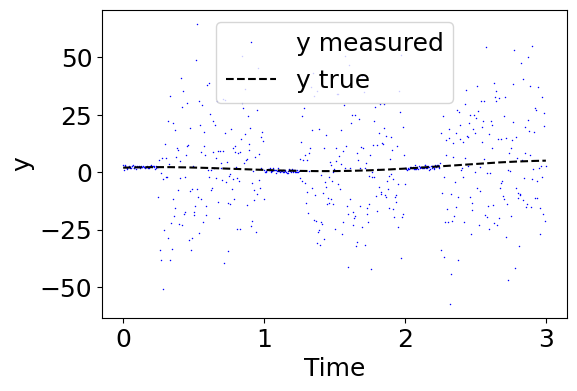

In [7]:
plot_tme(t, y, y_tilde)

# Candidate models

In [8]:
model_1_H = np.vstack([t, np.sin(t), np.cos(2*t)]).T

# Minimum Variance Estimate: Gauss-Markov Theorem

$\mathbf{\hat{x}}=(H^{\top}R^{-1}H)^{-1}H^{\top}R^{-1}\mathbf{\tilde{y}}$

In [9]:
R = np.diag( np.ravel(v_std)**2)
print(R)

[[2.5e-01 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 2.5e-01 0.0e+00 ... 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 2.5e-01 ... 0.0e+00 0.0e+00 0.0e+00]
 ...
 [0.0e+00 0.0e+00 0.0e+00 ... 4.0e+02 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 4.0e+02 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 ... 0.0e+00 0.0e+00 4.0e+02]]


### Model 1

In [10]:
x_1_hat = inv(model_1_H.T@inv(R)@model_1_H)@model_1_H.T@inv(R)@y_tilde

<Axes: xlabel='Time', ylabel='y'>

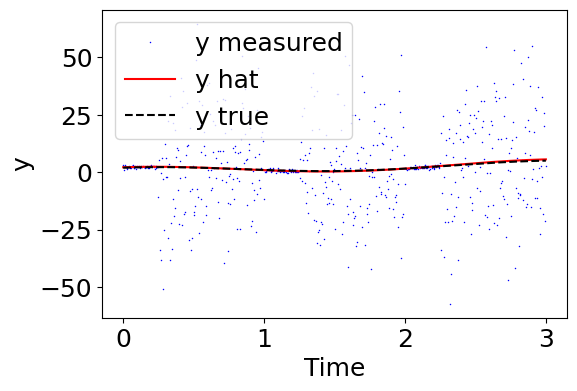

In [11]:
y_1_hat = model_1_H@x_1_hat
plot_tme(t, y, y_tilde, y_1_hat)

In [12]:
x_error = x_1_hat - x[0:3]
print(x_error)

[[ 0.13390131]
 [-0.17662838]
 [ 0.189352  ]]


# Covariance of x error

In [13]:
P = x_error@x_error.T
print(P)

[[ 0.01792956 -0.02365077  0.02535448]
 [-0.02365077  0.03119758 -0.03344494]
 [ 0.02535448 -0.03344494  0.03585418]]


# Cramer Rao Bound

The diagonal elements of P should (on average) be equal to (or bigger than) the diagonal elements of CRB (provided enough data or replicates).

In [14]:
CRB = inv(model_1_H.T@inv(R)@model_1_H)
print(CRB)

[[ 7.76558663e-03 -1.41714328e-02  4.55898544e-05]
 [-1.41714328e-02  3.03731901e-02  2.34729457e-03]
 [ 4.55898544e-05  2.34729457e-03  4.57115294e-03]]


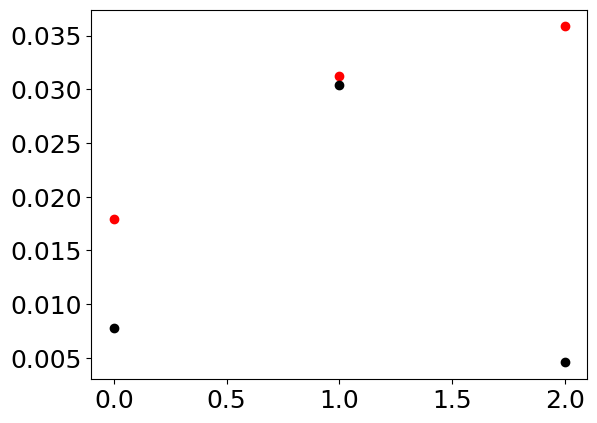

In [15]:
plt.plot(np.diag(P), 'o', color='red')
plt.plot(np.diag(CRB), 'o', color='black')

# Exercise

If you use the wrong R for your estimates (but the true R for CRB), than does your P get much worse than the CRB (worse being larger)?

# Excercise

Run the noisy measurement generation and determine the resulting estimation errors many times to show that on average the estimation error variance of the LLS estimates does converge to the CRB. Then show that if you use the wrong R, on average you will get larger errors.

In [16]:
# Define function to get new noisy measurements

def get_noisy_measurements(y):

  noise_mean = 0

  noise_std_1 = 20
  noise_std_2 = 0.5

  v = []
  v_std = []
  noise_i = 1
  n_chunks = 0
  while len(v)<len(t):
      if noise_i == 1:
          noise_i = 2
          noise_std = noise_std_2
          chunk_size = 50
      else:
          noise_i = 1
          noise_std = noise_std_1
          chunk_size = 150

      v_std = np.hstack( (v_std, [noise_std]*chunk_size) )
      v = np.hstack( (v, np.random.normal(noise_mean, noise_std, chunk_size)) )
      n_chunks += 1

  v_std = v_std[0:len(t)]
  v = v[0:len(t)]

  v_std = np.column_stack(v_std).T
  v = np.column_stack(v).T

  y_tilde = y+v

  return y_tilde

In [22]:
# Iterate through many iterations with correct R

errors = [] # x_hat - x

for i in range(1000):
  y_tilde = get_noisy_measurements(y)
  x_1_hat = inv(model_1_H.T@inv(R)@model_1_H)@model_1_H.T@inv(R)@y_tilde
  error = x_1_hat - x[0:3]
  errors.append(error)

In [24]:
E = np.hstack(errors)
expected_P_diag = np.std(E, axis=1)**2

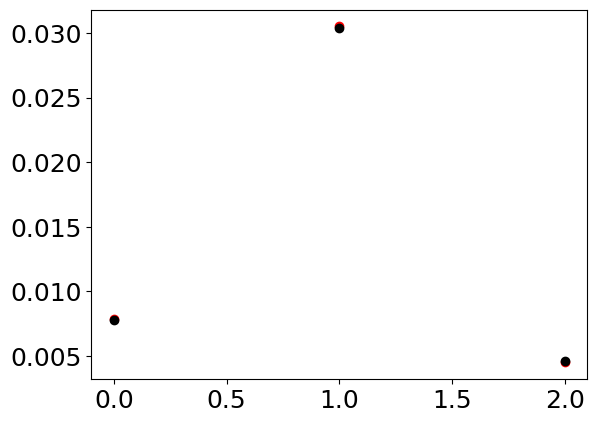

In [27]:
plt.plot(expected_P_diag, 'o', color='red')
plt.plot(np.diag(CRB), 'o', color='black')

In [28]:
errors_incorrect = [] # x_hat - x

for i in range(1000):
  R = np.eye(len(y_tilde))
  y_tilde = get_noisy_measurements(y)
  x_1_hat = inv(model_1_H.T@inv(R)@model_1_H)@model_1_H.T@inv(R)@y_tilde
  error = x_1_hat - x[0:3]
  errors_incorrect.append(error)

In [29]:
E = np.hstack(errors_incorrect)
expected_P_diag_incorrect = np.std(E, axis=1)**2

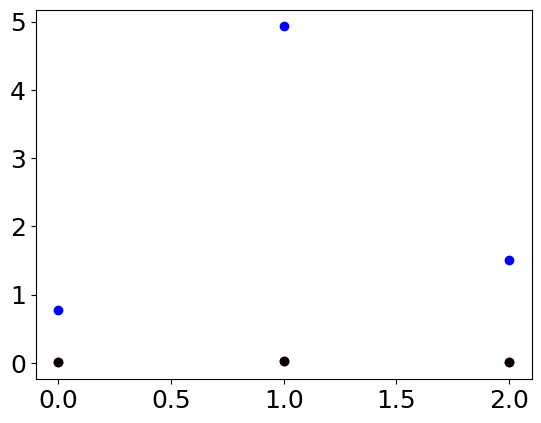

In [30]:
plt.plot(expected_P_diag, 'o', color='red')
plt.plot(np.diag(CRB), 'o', color='black')
plt.plot(expected_P_diag_incorrect, 'o', color='blue')